Link to Drive for CDs dataset: https://drive.google.com/drive/folders/1t2Y24NSpGlT2M29zJUDvvEg2KfP0JqkN?usp=share_link

# Preprocessing...

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import torch
import json
import matplotlib.pyplot as plt
import os
import tqdm
import pickle
from pathlib import Path
from torch.utils.data import DataLoader
from sklearn.metrics import ndcg_score
np.random.seed(0)

In [ ]:
!wget https://jmcauley.ucsd.edu/data/amazon_v2/categoryFiles/CDs_and_Vinyl.json.gz --no-check-certificate 

--2023-01-21 10:47:56--  https://jmcauley.ucsd.edu/data/amazon_v2/categoryFiles/CDs_and_Vinyl.json.gz
Resolving jmcauley.ucsd.edu (jmcauley.ucsd.edu)... 137.110.160.73
Connecting to jmcauley.ucsd.edu (jmcauley.ucsd.edu)|137.110.160.73|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 1172666826 (1.1G) [application/x-gzip]
Saving to: ‘CDs_and_Vinyl.json.gz’

CDs_and_Vinyl.json.  36%[======>             ] 405.80M  46.2MB/s    eta 11s    ^C


In [ ]:
!gunzip CDs_and_Vinyl.json.gz

In [ ]:
!wget https://jmcauley.ucsd.edu/data/amazon_v2/metaFiles2/meta_CDs_and_Vinyl.json.gz --no-check-certificate 

--2023-01-17 11:31:31--  https://jmcauley.ucsd.edu/data/amazon_v2/metaFiles2/meta_CDs_and_Vinyl.json.gz
Resolving jmcauley.ucsd.edu (jmcauley.ucsd.edu)... 137.110.160.73
Connecting to jmcauley.ucsd.edu (jmcauley.ucsd.edu)|137.110.160.73|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 161716387 (154M) [application/x-gzip]
Saving to: ‘meta_CDs_and_Vinyl.json.gz’

meta_CDs_and_Vinyl. 100%[===================>] 154.22M  90.1MB/s    in 1.7s    

2023-01-17 11:31:32 (90.1 MB/s) - ‘meta_CDs_and_Vinyl.json.gz’ saved [161716387/161716387]



In [ ]:
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import FreqDist
import re
from nltk.tokenize import RegexpTokenizer
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize,pos_tag
import pandas as pd

In [ ]:
save_path='/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/Recommender/cds/'

In [ ]:
df_review=pd.read_csv(save_path+'df_reviews.csv')

In [ ]:
df_meta=pd.read_csv(save_path+'df_meta.csv')

In [ ]:
df_review.drop(df_review.index[~df_review['asin'].isin(df_meta['asin'])], inplace=True) 

In [ ]:
sentires_dir='/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/Recommender/cds/CDs_and_Vinyl'
test_length=5
sample_ratio=2
val_length=1
neg_length=50
dataset='cds_and_vinyl'
save_path='/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/Recommender/cds/'

In [ ]:
def get_user_item_dict(df_review,items_list):
  user_dict = {}
  item_dict = {}
  j=0
  # removed_users=['A1ULCCHD1QNOS5','A1ZS098EKPVT8F','A1K1WK6I122RX2','A2PAFKGAUSBMIE','AAOYA0DKWED4W','AJS9Q2JYS3DLJ','ADOF1VKGDCBWF','A3G11XDKGXZT9Q','A1R233YLWSRBTC','A3VH9QMH2UTX9D','A15DZOS6KVANQH']    
  for index, row in df_review.iterrows():
    if j%100000==0:
      print(j)
    j+=1
    user=row['reviewerID']
    item=row['asin']
    if item in items_list:
      if user not in user_dict:
          user_dict[user] = [item]
      else:
          user_dict[user].append(item)
      if item not in item_dict:
          item_dict[item] = [user]
      else:
          item_dict[item].append(user)
  return user_dict,item_dict

In [ ]:
df_meta.loc[df_meta['feature'].str.len()<15]

In [ ]:
def get_average_vect_train(df,not_in_columns):
  df1=df.copy()
  df1['main_word']=np.where(df1['replaced_word'] == df1[not_in_columns],1,0)
  df1=df1[df1['main_word']==1]
  if df1.empty:
    df1=df.copy()
    df1['main_word']=np.where(df1['logit']==5.0,1,0)
    df1=df1[df1['main_word']==1]
  if df1.empty:
    df1=df.copy()
    df1['main_word']=np.where(df1['logit']==12.0,1,0)
    df1=df1[df1['main_word']==1]
  lists=df1.loc[:, ~df1.columns.isin([not_in_columns,'replaced_word','logit','main_word'])].values
  words=df1[not_in_columns].values
  # print(words)
  vects=[sub_list[0] for sub_list in lists]
  average=np.average(np.array(vects),axis=0)
  # print(vects)
  # print(average)
  # print(df)
  # print(words)
  # print(df)
  return average,list(words)

In [ ]:
def get_average_vect_test(weights,tensor_vect):
  # weights=torch.FloatTensor(weights).to(device)
  weights=torch.transpose(weights.repeat(tensor_vect.shape[1],1),0,1)
  average=torch.mean(weights*tensor_vect,axis=0).to(device)
  return average

In [ ]:
import os

In [ ]:
from typing_extensions import final
def get_item_matrix(item_name_dict,items_list):
  print('----- get items matrix -------')
  item_quality_matrix = np.zeros((len(item_name_dict), 1536))
  print((len(item_name_dict)))
  i=0
  features={}
  for item_id in items_list:
    if item_id in item_name_dict.keys():
      item=item_name_dict[item_id]
      features[item]=[]
      if i%100==0:
        print(i)
      i+=1
      # if i<950:
      #   continue
      final_vector=[]
      # print(item_id)
      df_vect_desc_item= pd.read_json(save_path+'descriptions_bert/'+'{}.json'.format(item_id))
      df_vect_title_item= pd.read_json(save_path+'titles_bert/'+'{}.json'.format(item_id))
      # df_vect_feature_item= pd.read_json(save_path+'features_bert/'+'{}.json'.format(item_id))
      
      # print(item_id)
      # print(df_vect_desc_item)

      average_vect_desc,words_desc=get_average_vect_train(df_vect_desc_item,'description_words')
      average_vect_title,words_title=get_average_vect_train(df_vect_title_item,'title_words')
      # average_vect_feature,words_feature=get_average_vect_train(df_vect_feature_item,'feature_words')
      # print(average_vect_title.shape)
      features[item].append(words_desc)
      features[item].append(words_title)
      # features[item].append(words_feature)
      # features[item].append(words_senti)
      # features[item].append([rank])
      final_vector=list(average_vect_desc)
      final_vector+=list(average_vect_title)
      # final_vector+=list(average_vect_feature)
  # final_vector+=list(average_bert_sentiment)
  # final_vector+=[rank]
  
      if len(final_vector)>1536:
          print(len(list(average_vect_desc)))
          print(len(list(average_vect_title)))
          # print(len(list(average_vect_feature)))
          # print(len(list(average_bert_sentiment)))
          print(item_id)
      item_quality_matrix[item]=final_vector
      # print(item_quality_matrix)

  item_quality_matrix = np.array(item_quality_matrix, dtype='float32')
  return item_quality_matrix,features

In [ ]:
def get_user_matrix(item_matrix,inv_user_name_dict,item_name_dict):
  user_quality_matrix = np.zeros((len(inv_user_name_dict), 1536))
  i=0
  print('----- get users matrix -------')
  print((len(inv_user_name_dict)))
  for  user in inv_user_name_dict.keys():
    if i%1000==0:
      print(i)
    i+=1
    user_id= inv_user_name_dict[user]
    final_vector=[]
    items_interacted=df_review[df_review['reviewerID']==user_id ]
    # mean_rate=np.average(items_interacted['overall'].values)
    # weights=[]
    for item_id in items_interacted['asin'].values:
      if item_id in item_name_dict.keys():
        item=item_name_dict[item_id]
        # weight=items_interacted[items_interacted['asin']==item_id]['overall'].values[0]-mean_rate
        # weights.append(weight)
        final_vector.append(item_matrix[item])
    # if np.sum(weights)>0 or np.sum(weights)<0:
    #   final_average=np.average(final_vector,weights=weights,axis=0)
    # else:
    final_average=np.average(final_vector,axis=0)
    if ~np.isnan(np.sum(final_average)):
      user_quality_matrix[user]=final_average
    else:
      print(user_id)
  user_quality_matrix = np.array(user_quality_matrix, dtype='float32')
  return user_quality_matrix

In [ ]:
def sample_training_pairs(user, training_items, item_set, sample_ratio=5):
    positive_items = set(training_items)
    negative_items = set()
    for item in item_set:
        if item not in positive_items:
            negative_items.add(item)
    neg_length = len(positive_items) * sample_ratio
    negative_items = np.random.choice(np.array(list(negative_items)), neg_length, replace=False)
    train_pairs = []
    for p_item in positive_items:
        train_pairs.append([user, p_item, 1])
    for n_item in negative_items:
        train_pairs.append([user, n_item, 0])
    return train_pairs

In [ ]:
import glob
def get_items_list():
  items_list=[]
  names=glob.glob(save_path+"titles_bert/*.json")
  for name in names:
    items_list.append(name.split('/')[-1].split('_')[-1][0:-5])
  return items_list

In [ ]:
from re import S
import torch
import numpy as np
import json
import pickle
# from torch._C import R
import tqdm
from torch.random import seed


class AmazonDataset():
    def __init__(self):
        super().__init__()

        self.user_name_dict = {}  # rename users to integer names
        self.item_name_dict = {}
        # self.feature_name_dict = {}

        self.features = {}  # feature list
        self.users = []
        self.items = []

        # the interacted items for each user, sorted with date {user:[i1, i2, i3, ...], user:[i1, i2, i3, ...]}
        self.user_hist_inter_dict = {}
        # the interacted users for each item
        self.item_hist_inter_dict = {}  

        self.user_num = None
        self.item_num = None
        self.feature_num = 1536# number of features

        self.user_feature_matrix = None  # user aspect attention matrix
        self.item_feature_matrix = None  # item aspect quality matrix

        self.training_data = None
        self.test_data = None
        self.pre_processing()
        self.get_user_item_feature_matrix()
        self.sample_training()  # sample training data, for traning BPR loss
        self.sample_test()  # sample test data

    def pre_processing(self,):
        self.items_list=items_list
        user_dict, item_dict = get_user_item_dict(df_review,self.items_list)  # not sorted with time
        self.items_list=list(item_dict.keys())
        print('num_items: ',len(item_dict))
        user_item_date_dict = {}   # {(user, item): date, (user, item): date ...}  # used to remove duplicate
        # # removed_users=['A1ULCCHD1QNOS5','A1ZS098EKPVT8F','A1K1WK6I122RX2','A2PAFKGAUSBMIE','AAOYA0DKWED4W','AJS9Q2JYS3DLJ','ADOF1VKGDCBWF','A3G11XDKGXZT9Q','A1R233YLWSRBTC','A3VH9QMH2UTX9D','A15DZOS6KVANQH']
        # print(df_review.shape)
        for i, row in df_review.iterrows():
            user = row['reviewerID']
            # if user not in removed_users:
            item = row['asin']
            date = row['unixReviewTime']
            if item in self.items_list:
              if user in user_dict and item in user_dict[user] and (user, item) not in user_item_date_dict:
                  user_item_date_dict[(user, item)] = date
        
        # rename users, items, and features to integer names
        user_name_dict = {}
        item_name_dict = {}
        # feature_name_dict = {}
        # features = get_feature_list(df_bert_sentiment,df_bert_desc,)
        
        count = 0
        for user in user_dict:
            if user not in user_name_dict:
                user_name_dict[user] = count
                count += 1
        count = 0
        for item in item_dict:
            if item not in item_name_dict:
                item_name_dict[item] = count
                count += 1
        self.inv_user_name_dict = {v: k for k, v in user_name_dict.items()}
        self.inv_item_name_dict = {v: k for k, v in item_name_dict.items()}
        

        renamed_user_item_date_dict = {}
        for key, value in user_item_date_dict.items():
            renamed_user_item_date_dict[user_name_dict[key[0]], item_name_dict[key[1]]] = value

        # sort with date
        renamed_user_item_date_dict  = dict(sorted(renamed_user_item_date_dict .items(), key=lambda item: item[1]))

        user_hist_inter_dict = {}  # {"u1": [i1, i2, i3, ...], "u2": [i1, i2, i3, ...]}, sort with time
        item_hist_inter_dict = {}
        # ranked_user_item_dict = {}  # {"u1": [i1, i2, i3, ...], "u2": [i1, i2, i3, ...]}
        for key, value in renamed_user_item_date_dict.items():
            user = key[0]
            item = key[1]
            if user not in user_hist_inter_dict:
                user_hist_inter_dict[user] = [item]
            else:
                user_hist_inter_dict[user].append(item)
            if item not in item_hist_inter_dict:
                item_hist_inter_dict[item] = [user]
            else:
                item_hist_inter_dict[item].append(user)

        user_hist_inter_dict = dict(sorted(user_hist_inter_dict.items()))
        item_hist_inter_dict = dict(sorted(item_hist_inter_dict.items()))

        users = list(user_hist_inter_dict.keys())
        items = list(item_hist_inter_dict.keys())

        self.user_name_dict = user_name_dict
        self.item_name_dict = item_name_dict
        self.user_hist_inter_dict = user_hist_inter_dict
        self.item_hist_inter_dict = item_hist_inter_dict
        self.users = users
        self.items = items
        self.user_num = len(users)
        self.item_num = len(items)
        return True
    
    def get_user_item_feature_matrix(self,):
        # exclude test data from the sentiment data to construct matrix
        train_u_i_set = set()
        for user, items in self.user_hist_inter_dict.items():
            items = items[:-test_length]
            for item in items:
                train_u_i_set.add((user, item))

        self.item_feature_matrix,self.item_features= get_item_matrix(self.item_name_dict,self.items_list)
        self.user_feature_matrix = get_user_matrix(self.item_feature_matrix,self.inv_user_name_dict,self.item_name_dict)
        
        return True
    
    def sample_training(self):
        print('======================= sample training data =======================')
        # training_data = []
        # training_pairs = np.loadtxt(save_path+'training_data.txt',dtype=str)
        # for pair in training_pairs:
        #   # print(self.user_name_dict)
        #   # print(pair[0])
        #   if pair[0] in self.user_name_dict.keys() and pair[1] in self.item_name_dict.keys():
        #     training_data.append([self.user_name_dict[pair[0]],self.item_name_dict[pair[1]],int(pair[2])])


        print(self.user_feature_matrix.shape, self.item_feature_matrix.shape)
        training_data = []
        item_set = set(self.items)
        for user, items in self.user_hist_inter_dict.items():
            if len(items)>15:
              items = items[:-(test_length)]
              training_pairs = sample_training_pairs(
                  user, 
                  items, 
                  item_set, 
                  sample_ratio)
              for pair in training_pairs:
                  training_data.append(pair)
        print('# training samples :', len(training_data))
        self.training_data = np.array(training_data)
      
        return True
    
    def sample_test(self):
        print('======================= sample test data =======================')
        # user_item_label_list = []  # [[u, [item1, item2, ...], [l1, l2, ...]], ...]
        # with open(save_path+'test_data.pickle', 'rb') as f:
        #     test_pairs= pickle.load(f)
        # for user_id in test_pairs.keys():
        #   user=self.user_name_dict[user_id]
        #   items_ids=test_pairs[user_id][0]
        #   labels=test_pairs[user_id][1]
        #   items=np.array([self.item_name_dict[item] for item in items_ids if item in self.item_name_dict])
        #   labels=np.array([float(labels[i]) for i in range(len(labels)) if items_ids[i] in self.item_name_dict])
        #   user_item_label_list.append([user,items,labels])
        # print('# test samples :', len(user_item_label_list))
        # self.test_data = np.array(user_item_label_list)

        # validation_data = []  # [[u, [item1, item2, ...], [l1, l2, ...]], ...]
        # with open(save_path+'validation_data.pickle', 'rb') as f:
        #     validation_pairs= pickle.load(f)
        # for user_id in validation_pairs.keys():
        #   user=self.user_name_dict[user_id]
        #   items_ids=validation_pairs[user_id][0]
        #   labels=validation_pairs[user_id][1]
        #   items=np.array([self.item_name_dict[item] for item in items_ids if item in self.item_name_dict])
        #   labels=np.array([float(labels[i]) for i in range(len(labels)) if items_ids[i] in self.item_name_dict])
        #   validation_data.append([user,items,labels])
        # print('# validation samples :', len(validation_data))
        # self.validation_data = np.array(validation_data)


        user_item_label_list = []  # [[u, [item1, item2, ...], [l1, l2, ...]], ...]
        validation_data=[]
        for user, items in self.user_hist_inter_dict.items():
          if len(items)>15:
            # print(items)
            items1 = items[-(test_length):-(val_length)]
            items2 = items[-(val_length):]
            # print(items1)
            # print(items2)
            user_item_label_list.append([user, items1, np.ones(len(items1))])  # add the test items
            validation_data.append([user, items2, np.ones(len(items2))])
            neg_length1=len(items1)*5
            neg_length2=len(items2)*5
            negative_items1 = [item for item in self.items if 
                item not in self.user_hist_inter_dict[user]]  # the not interacted items
            # print(len(negative_items1))
            negative_items1 = np.random.choice(np.array(negative_items1), neg_length1, replace=False)
            negative_items2 = np.random.choice(np.array(negative_items1), neg_length2, replace=False)

            user_item_label_list[-1][1] = np.concatenate((user_item_label_list[-1][1], negative_items1), axis=0)
            user_item_label_list[-1][2] = np.concatenate((user_item_label_list[-1][2], np.zeros(neg_length1)), axis=0)

            validation_data[-1][1] = np.concatenate((validation_data[-1][1], negative_items2), axis=0)
            validation_data[-1][2] = np.concatenate((validation_data[-1][2], np.zeros(neg_length2)), axis=0)
        print('# test samples :', len(user_item_label_list))
        print('# validation samples :', len(validation_data))
        self.test_data = np.array(user_item_label_list)
        self.validation_data=np.array(validation_data)
        return True

    def save(self, save_path):
        return True
    
    def load(self):
        return False

In [ ]:
def amazon_preprocessing():
    rec_dataset = AmazonDataset()
    return rec_dataset

In [ ]:
def dataset_init():
	if dataset == "yelp":
		rec_dataset = yelp_preprocessing()
	elif dataset == "cell_phones" or "kindle_store" or "electronic" or "cds_and_vinyl":
		rec_dataset = amazon_preprocessing()
	return rec_dataset

In [ ]:
dataset="cds_and_vinyl"
gpu=True
cuda='0'
weight_decay=0.00001
lr=0.01
epochs=80
batch_size=64
rec_k=5

In [ ]:
import numpy as np
from torch.utils.data import Dataset
class UserItemInterDataset(Dataset):
    def __init__(self, data, user_feature_matrix, item_feature_matrix):
        self.data = data
        self.user_feature_matrix = user_feature_matrix
        self.item_feature_matrix = item_feature_matrix

    def __getitem__(self, index):
        user = self.data[index][0]
        item = self.data[index][1]
        label = self.data[index][2]
        user_feature = self.user_feature_matrix[user]
        item_feature = self.item_feature_matrix[item]
        return user_feature, item_feature, label
    def __len__(self):
        return len(self.data)

# Train Black-box model...

In [ ]:
import numpy as np
import torch
from sklearn.metrics import ndcg_score

In [ ]:
def compute_ndcg(test_data, user_feature_matrix, item_feature_matrix, k, model, device):
    model.eval()
    ndcgs = []
    with torch.no_grad():
        for row in test_data:
            user = row[0]
            items = row[1]
            gt_labels = row[2]
            user_features = np.array([user_feature_matrix[user] for i in range(len(items))])
            item_features = np.array([item_feature_matrix[item] for item in items])
            scores = model(torch.from_numpy(user_features).to(device),
                                    torch.from_numpy(item_features).to(device)).squeeze()
            scores = np.array(scores.to('cpu'))
            ndcg = ndcg_score([gt_labels], [scores], k=k)
            ndcgs.append(ndcg)
    ave_ndcg = np.mean(ndcgs)
    return ave_ndcg


In [ ]:
import torch
import numpy as np
import os
import tqdm
import pickle
from pathlib import Path
from torch.utils.data import DataLoader

In [ ]:
from numpy import core

class BaseRecModel(torch.nn.Module):
    def __init__(self, feature_length):
        super(BaseRecModel, self).__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(feature_length * 2, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, user_feature, item_feature):
        fusion = torch.cat((user_feature, item_feature), 1)
        out = self.fc(fusion)
        return out


In [ ]:
if gpu:
  device = torch.device('cuda:%s' % cuda)
else:
  device = 'cpu'
print(device)

cuda:0


In [ ]:
rec_dataset = dataset_init()

In [ ]:
with open(os.path.join(save_path, dataset + "_dataset_obj_2.pickle"), 'rb') as inp:
  rec_dataset = pickle.load(inp)

In [ ]:
import matplotlib.pyplot as plt

Using CUDA 0
init ndcg: 0.282767313364255


  0%|          | 0/80 [00:00<?, ?it/s]

epoch 0:  training loss:  0.6129235


  1%|▏         | 1/80 [00:26<35:02, 26.61s/it]

epoch 0:  training loss:  0.6129235 NDCG_validation:  0.4291378945191202


  2%|▎         | 2/80 [00:47<29:50, 22.96s/it]

epoch 1:  training loss:  0.52338547


  4%|▍         | 3/80 [01:07<27:57, 21.79s/it]

epoch 2:  training loss:  0.46956953


  5%|▌         | 4/80 [01:27<26:52, 21.22s/it]

epoch 3:  training loss:  0.44381717


  6%|▋         | 5/80 [01:48<26:08, 20.91s/it]

epoch 4:  training loss:  0.42542708


  8%|▊         | 6/80 [02:08<25:34, 20.73s/it]

epoch 5:  training loss:  0.41204154


  9%|▉         | 7/80 [02:28<25:02, 20.58s/it]

epoch 6:  training loss:  0.40105578


 10%|█         | 8/80 [02:48<24:32, 20.45s/it]

epoch 7:  training loss:  0.39171344


 11%|█▏        | 9/80 [03:09<24:05, 20.36s/it]

epoch 8:  training loss:  0.38317624


 12%|█▎        | 10/80 [03:29<23:38, 20.26s/it]

epoch 9:  training loss:  0.37634182
epoch 10:  training loss:  0.36899644


 14%|█▍        | 11/80 [03:55<25:24, 22.09s/it]

epoch 10:  training loss:  0.36899644 NDCG_validation:  0.7115241013054225


 15%|█▌        | 12/80 [04:15<24:20, 21.48s/it]

epoch 11:  training loss:  0.36251155


 16%|█▋        | 13/80 [04:35<23:30, 21.06s/it]

epoch 12:  training loss:  0.35650292


 18%|█▊        | 14/80 [04:55<22:54, 20.82s/it]

epoch 13:  training loss:  0.35071734


 19%|█▉        | 15/80 [05:15<22:19, 20.61s/it]

epoch 14:  training loss:  0.34568077


 20%|██        | 16/80 [05:36<21:51, 20.49s/it]

epoch 15:  training loss:  0.34040752


 21%|██▏       | 17/80 [05:56<21:24, 20.38s/it]

epoch 16:  training loss:  0.33611637


 22%|██▎       | 18/80 [06:16<20:58, 20.30s/it]

epoch 17:  training loss:  0.33109093


 24%|██▍       | 19/80 [06:36<20:35, 20.26s/it]

epoch 18:  training loss:  0.32644656


 25%|██▌       | 20/80 [06:56<20:14, 20.24s/it]

epoch 19:  training loss:  0.32187378
epoch 20:  training loss:  0.3182147


 26%|██▋       | 21/80 [07:22<21:24, 21.78s/it]

epoch 20:  training loss:  0.3182147 NDCG_validation:  0.7560824768966159


 28%|██▊       | 22/80 [07:42<20:33, 21.27s/it]

epoch 21:  training loss:  0.31349957


 29%|██▉       | 23/80 [08:02<19:51, 20.90s/it]

epoch 22:  training loss:  0.30982986


 30%|███       | 24/80 [08:22<19:17, 20.68s/it]

epoch 23:  training loss:  0.30580398


 31%|███▏      | 25/80 [08:42<18:47, 20.50s/it]

epoch 24:  training loss:  0.30231294


 32%|███▎      | 26/80 [09:02<18:19, 20.37s/it]

epoch 25:  training loss:  0.29820284


 34%|███▍      | 27/80 [09:22<17:54, 20.28s/it]

epoch 26:  training loss:  0.2945484


 35%|███▌      | 28/80 [09:42<17:33, 20.25s/it]

epoch 27:  training loss:  0.29129234


 36%|███▋      | 29/80 [10:03<17:23, 20.46s/it]

epoch 28:  training loss:  0.28783584


 38%|███▊      | 30/80 [10:23<16:57, 20.36s/it]

epoch 29:  training loss:  0.28418052
epoch 30:  training loss:  0.2808718


 39%|███▉      | 31/80 [10:49<17:52, 21.88s/it]

epoch 30:  training loss:  0.2808718 NDCG_validation:  0.7688554191584921


 40%|████      | 32/80 [11:09<17:05, 21.37s/it]

epoch 31:  training loss:  0.2775722


 41%|████▏     | 33/80 [11:29<16:26, 20.99s/it]

epoch 32:  training loss:  0.27374512


 42%|████▎     | 34/80 [11:49<15:53, 20.73s/it]

epoch 33:  training loss:  0.27116096


 44%|████▍     | 35/80 [12:09<15:24, 20.54s/it]

epoch 34:  training loss:  0.2679187


 45%|████▌     | 36/80 [12:29<14:58, 20.43s/it]

epoch 35:  training loss:  0.2641884


 46%|████▋     | 37/80 [12:50<14:34, 20.33s/it]

epoch 36:  training loss:  0.26144263


 48%|████▊     | 38/80 [13:10<14:11, 20.26s/it]

epoch 37:  training loss:  0.2584729


 49%|████▉     | 39/80 [13:30<13:48, 20.20s/it]

epoch 38:  training loss:  0.2553127


 50%|█████     | 40/80 [13:51<13:35, 20.38s/it]

epoch 39:  training loss:  0.25230473
epoch 40:  training loss:  0.24938053


 51%|█████▏    | 41/80 [14:16<14:13, 21.89s/it]

epoch 40:  training loss:  0.24938053 NDCG_validation:  0.7749640548068283


 52%|█████▎    | 42/80 [14:36<13:30, 21.32s/it]

epoch 41:  training loss:  0.24605912


 54%|█████▍    | 43/80 [14:56<12:55, 20.95s/it]

epoch 42:  training loss:  0.24331671


 55%|█████▌    | 44/80 [15:16<12:26, 20.72s/it]

epoch 43:  training loss:  0.24037616


 56%|█████▋    | 45/80 [15:36<11:57, 20.50s/it]

epoch 44:  training loss:  0.2377181


 57%|█████▊    | 46/80 [15:56<11:34, 20.42s/it]

epoch 45:  training loss:  0.2352352


 59%|█████▉    | 47/80 [16:17<11:10, 20.32s/it]

epoch 46:  training loss:  0.23191774


 60%|██████    | 48/80 [16:37<10:47, 20.24s/it]

epoch 47:  training loss:  0.22907309


 61%|██████▏   | 49/80 [16:57<10:26, 20.20s/it]

epoch 48:  training loss:  0.22630943


 62%|██████▎   | 50/80 [17:17<10:10, 20.35s/it]

epoch 49:  training loss:  0.2242377
epoch 50:  training loss:  0.2215449


 64%|██████▍   | 51/80 [17:43<10:34, 21.88s/it]

epoch 50:  training loss:  0.2215449 NDCG_validation:  0.7674679611737333


 65%|██████▌   | 52/80 [18:03<09:58, 21.38s/it]

epoch 51:  training loss:  0.21794148


 66%|██████▋   | 53/80 [18:23<09:26, 20.97s/it]

epoch 52:  training loss:  0.2156794


 68%|██████▊   | 54/80 [18:43<08:58, 20.69s/it]

epoch 53:  training loss:  0.21289706


 69%|██████▉   | 55/80 [19:03<08:33, 20.53s/it]

epoch 54:  training loss:  0.21033114


 70%|███████   | 56/80 [19:23<08:09, 20.40s/it]

epoch 55:  training loss:  0.20737706


 71%|███████▏  | 57/80 [19:44<07:47, 20.32s/it]

epoch 56:  training loss:  0.20550014


 72%|███████▎  | 58/80 [20:04<07:25, 20.26s/it]

epoch 57:  training loss:  0.20305064


 74%|███████▍  | 59/80 [20:25<07:11, 20.54s/it]

epoch 58:  training loss:  0.20049775


 75%|███████▌  | 60/80 [20:45<06:48, 20.44s/it]

epoch 59:  training loss:  0.19783486
epoch 60:  training loss:  0.19571011


 76%|███████▋  | 61/80 [21:10<06:57, 21.95s/it]

epoch 60:  training loss:  0.19571011 NDCG_validation:  0.770923786605518


 78%|███████▊  | 62/80 [21:31<06:24, 21.38s/it]

epoch 61:  training loss:  0.1924739


 79%|███████▉  | 63/80 [21:51<05:57, 21.01s/it]

epoch 62:  training loss:  0.19049442


 80%|████████  | 64/80 [22:11<05:31, 20.72s/it]

epoch 63:  training loss:  0.18894523


 81%|████████▏ | 65/80 [22:31<05:07, 20.52s/it]

epoch 64:  training loss:  0.18602182


 82%|████████▎ | 66/80 [22:51<04:45, 20.39s/it]

epoch 65:  training loss:  0.18347627


 84%|████████▍ | 67/80 [23:11<04:24, 20.35s/it]

epoch 66:  training loss:  0.18131322


 85%|████████▌ | 68/80 [23:31<04:03, 20.27s/it]

epoch 67:  training loss:  0.17860548


 86%|████████▋ | 69/80 [23:52<03:45, 20.48s/it]

epoch 68:  training loss:  0.17685387


 88%|████████▊ | 70/80 [24:12<03:23, 20.36s/it]

epoch 69:  training loss:  0.17470725
epoch 70:  training loss:  0.17231621


 89%|████████▉ | 71/80 [24:38<03:16, 21.89s/it]

epoch 70:  training loss:  0.17231621 NDCG_validation:  0.7701936460215051


 90%|█████████ | 72/80 [24:58<02:50, 21.37s/it]

epoch 71:  training loss:  0.1708911


 91%|█████████▏| 73/80 [25:18<02:27, 21.03s/it]

epoch 72:  training loss:  0.16883104


 92%|█████████▎| 74/80 [25:38<02:04, 20.81s/it]

epoch 73:  training loss:  0.16563115


 94%|█████████▍| 75/80 [25:59<01:43, 20.63s/it]

epoch 74:  training loss:  0.1646738


 95%|█████████▌| 76/80 [26:19<01:21, 20.48s/it]

epoch 75:  training loss:  0.1624762


 96%|█████████▋| 77/80 [26:39<01:01, 20.35s/it]

epoch 76:  training loss:  0.1600154


 98%|█████████▊| 78/80 [26:59<00:40, 20.30s/it]

epoch 77:  training loss:  0.15783876


 99%|█████████▉| 79/80 [27:20<00:20, 20.56s/it]

epoch 78:  training loss:  0.15636705


100%|██████████| 80/80 [27:40<00:00, 20.76s/it]

epoch 79:  training loss:  0.15411894



ndcg_test:  0.652819334898632


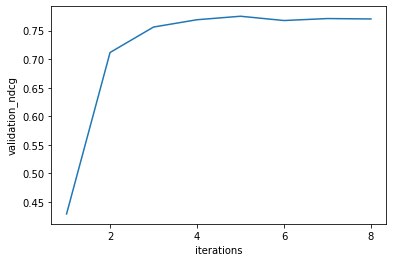

In [ ]:
def train_base_recommendation():
    losses_all=[]
    ndcgs=[]
    if gpu:
        device = torch.device('cuda:%s' % cuda)
    else:
        device = 'cpu'
    Path(save_path).mkdir(parents=True, exist_ok=True)
    with open(os.path.join(save_path,dataset + "_dataset_obj.pickle"), 'wb') as outp:
        pickle.dump(rec_dataset, outp, pickle.HIGHEST_PROTOCOL)

    train_loader = DataLoader(dataset=UserItemInterDataset(rec_dataset.training_data, 
                                rec_dataset.user_feature_matrix, 
                                rec_dataset.item_feature_matrix),
                          batch_size=batch_size,
                          shuffle=True)

    model = BaseRecModel(rec_dataset.feature_num).to(device)
    loss_fn = torch.nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

    out_path = os.path.join("./logs", dataset + "_logs")
    Path(out_path).mkdir(parents=True, exist_ok=True)

    ndcg = compute_ndcg(rec_dataset.validation_data, 
            rec_dataset.user_feature_matrix, 
            rec_dataset.item_feature_matrix, 
            rec_k, 
            model, 
            device)
    print('init ndcg:', ndcg)
    for epoch in tqdm.trange(epochs):
        model.train()
        optimizer.zero_grad()
        losses = []
        for user_behaviour_feature, item_aspect_feature, label in train_loader:
            user_behaviour_feature = user_behaviour_feature.to(device)
            item_aspect_feature = item_aspect_feature.to(device)
            label = label.float().to(device)
            out = model(user_behaviour_feature, item_aspect_feature).squeeze()
            loss = loss_fn(out, label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            losses.append(loss.to('cpu').detach().numpy())
            ave_train = np.mean(np.array(losses))
            losses_all.append(ave_train)
        print('epoch %d: ' % epoch, 'training loss: ', ave_train)
      
        # compute necg
        if epoch % 10 == 0:
            ndcg = compute_ndcg(rec_dataset.validation_data, 
            rec_dataset.user_feature_matrix, 
            rec_dataset.item_feature_matrix, 
            rec_k, 
            model, 
            device)
            print('epoch %d: ' % epoch, 'training loss: ', ave_train, 'NDCG_validation: ', ndcg)

            ndcgs.append(ndcg)
    torch.save(model.state_dict(), os.path.join(save_path, "model.model"))
    ndcg_test = compute_ndcg(rec_dataset.test_data, 
            rec_dataset.user_feature_matrix, 
            rec_dataset.item_feature_matrix, 
            rec_k, 
            model, 
            device)
    print('\nndcg_test: ',ndcg_test)
    # plt.xlabel('iterations')
    # plt.ylabel('train_loss')
    # plt.xticks(np.arange(0,len(losses_all),100))
    # plt.plot(np.arange(0,len(losses_all)),losses_all)
    # plt.show()

    plt.xlabel('iterations')
    plt.ylabel('validation_ndcg')
    plt.xticks(np.arange(-2,len(ndcgs)+2,2))
    plt.plot(np.arange(1,len(ndcgs)+1),ndcgs)
    plt.show()
    return rec_dataset


if __name__ == "__main__":
    torch.manual_seed(0)
    np.random.seed(0)
    if gpu:
        os.environ["CUDA_VISIBLE_DEVICES"] =cuda
        print("Using CUDA",cuda)
    else:
        print("Using CPU")
    rec_dataset=train_base_recommendation()

In [ ]:
dataset="cds_and_vinyl"
base_model_path="/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/Recommender/cds/"
gpu=True
cuda='0'
data_obj_path="/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/Recommender/cds/"
rec_k=5
lam=100
gam=0.5
alp=0.2
user_mask=False
lr=0.01
step=250
mask_thresh=0.3
test_num=-1
# save_path="./explanation_objs/"

In [ ]:
import torch
import pickle
import os
from pathlib import Path

# User Perspective Features

In [ ]:
import json
import nltk

In [ ]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
def lemmatization(text):
    result=''
    wordnet = WordNetLemmatizer()
    for token,tag in pos_tag(text):
        pos=tag[0].lower()
        if pos not in ['a', 'r', 'n', 'v']:
            pos='n'
        # if pos in ['n','a']:   
        result+=wordnet.lemmatize(token,pos)+' '
    return result
def remove_stopwords(text):
    en_stopwords = stopwords.words('english')
    en_stopwords+=['may','could','that','without','iii','with','and','This','That','Those','These','the','The','brbr','so','it','such']
    result = []
    for token in text:
        if token not in en_stopwords:
            result.append(token)
            
    return result
def remove_punct(text):
    tokenizer = RegexpTokenizer(r"\w+")
    lst=tokenizer.tokenize(' '.join(text))
    return lst

def remove_tag(text):
    text=' '.join(text)
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def preprocess(text):
  chars=['&','%','#','@','^','>','<','\n','\\','\t',';','"','/']
  stwords=stopwords.words('english')
  for ch in chars:
    text=text.replace(ch,' ')
  text=" ".join(text.split())
  # text=text.lower()
  text_tokenized=word_tokenize(text)
  cleaned_text= remove_stopwords(text_tokenized)
  cleaned_text= remove_punct(cleaned_text)
  # cleaned_text=lemmatization(cleaned_text)
  cleaned_text=remove_tag(cleaned_text)
  cleaned_text=remove_urls(cleaned_text)
  cleaned_text=''.join([i for i in cleaned_text ])
  cleaned_text=[word for word in cleaned_text.split(' ') if len(word)>1]
  # print(cleaned_text)
  return ' '.join(cleaned_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
def preprocess_text_first(text):
  while '<' in text and '>' in text and text.index('<')<text.index('>'):
    toRemove=text[int(text.index('<')):int(text.index('>'))]+'>'
    text=text.replace(toRemove,' ')
  list_to_replace=['mso','gte','xml','false','#',',','!','-','\'','\"','[',']','/','\\n','\\','span','a-size-base','a-color-secondary','input type','header name','value','=','<a href= javascript:void(0) class= ','{','}','class=','header','<a href= javascript:void(0)','<','>','href',')','(',';','quot','&',':','javascript']
  for char in list_to_replace:
    text=text.replace(char,' ')
  for i in range(15):
    text=text.replace('  ',' ')
  # while 'if' in text and 'endif' in text and text.index('if')<text.index('endif'):
  #   # print(int(text.index('if')),int(text.index('endif')))
  #   toRemove=text[int(text.index('if')):int(text.index('endif'))]+'endif'
  #   text=text.replace(toRemove,' ')
  new_text=''
  for word in text.split(' '):
    if len(word)>1 and len(word)<35:
      new_text+=word+' '
  # new_text=lemmatization(new_text)
  # print(new_text)
  return new_text

In [ ]:
items_list=[]
users_list=[]
review_features={}
f=open(save_path+'CDs_and_Vinyl')
lines=f.readlines()
i=0
for line in lines:
  if i%5000==0:
    print(i)
  i+=1
  user_id = line.split('@')[0]
  item_id = line.split('@')[1]
  # if item_id in df_meta['asin'].values:
  users_list.append(user_id)
  items_list.append(item_id)
  l = len(user_id) + len(item_id)
  fosr_data = line[l+3:]
  for seg in fosr_data.split('||'):
    if (user_id,item_id) not in review_features.keys():
      review_features[(user_id,item_id)]=[]
    fos = seg.split(':')[0].strip('|')
    if len(fos.split('|')) > 1:
          feature = fos.split('|')[0]
          opinion = fos.split('|')[1]
          sentiment = fos.split('|')[2]
          sentence= seg.split(':')[1]
          if sentiment=='+1':
            senti=1
          else:
            senti=-1
          review_features[(user_id,item_id)].append([feature,opinion,senti,sentence])

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000
115000
120000
125000
130000
135000
140000
145000
150000
155000
160000
165000
170000
175000
180000
185000
190000
195000
200000
205000
210000
215000
220000
225000
230000
235000
240000
245000
250000
255000
260000
265000


In [ ]:
user_test_perspective={}
i=0
for (user_id , item_id) in review_features.keys():
  review_feature=review_features[(user_id,item_id)]
  if i%5000==0:
    print(i)
  i+=1
  for features in review_feature:
    sentence=features[3]
    sentence=preprocess_text_first(sentence)
    sentence=preprocess(sentence).lower()
    if (user_id , item_id) not in user_test_perspective.keys():
      final_vect=[]
    final_vect+=sentence.split(' ')
    for word in sentence.split(' '):
      # tokens=list(set(df_words[df_words['word']==word]['tokenized'].values))
      # for token in tokens:
        final_vect+=word.split(' ')
    final_vect=list(set(final_vect))
    new_final_vect=[]
    for word in final_vect:
      if len(word)>1:
        new_final_vect.append(word)
    user_test_perspective[(user_id , item_id)]=new_final_vect

In [ ]:
user_test_perspective

In [ ]:
rec_dataset.inv_item_name_dict[622]

'B00FL6ADNC'

# Train Explaination Generator Model


In [ ]:
class ExpOptimizationModel(torch.nn.Module):
    def __init__(self, base_model, rec_dataset, device):
        super(ExpOptimizationModel, self).__init__()
        self.base_model = base_model
        self.rec_dataset = rec_dataset
        self.device = device
        self.u_i_exp_dict = {}  # {(user, item): [f1, f2, f3 ...], ...}
        self.user_feature_matrix = torch.from_numpy(self.rec_dataset.user_feature_matrix).to(self.device)
        self.item_feature_matrix = torch.from_numpy(self.rec_dataset.item_feature_matrix).to(self.device)
        self.rec_dict, self.user_perspective_test_data = self.generate_rec_dict()
        self.dict_items_cf_feature={}

    def generate_rec_dict(self):
        rec_dict = {}
        correct_rec_dict = {}  # used for user-side evaluation
        for row in self.rec_dataset.test_data:
            user = row[0]
            items = row[1]
            labels = row[2]
            correct_rec_dict[user] = []
            user_features = self.user_feature_matrix[user].repeat(len(items), 1)
            scores = self.base_model(user_features,
                        self.item_feature_matrix[items]).squeeze()
            scores = np.array(scores.to('cpu'))
            sort_index = sorted(range(len(scores)), key=lambda k: scores[k], reverse=True)
            sorted_items = [items[i] for i in sort_index]
            rec_dict[user] = sorted_items
            for i in range(rec_k):  # find the correct items and add to the user side test data
                if labels[sort_index[i]] == 1:
                    correct_rec_dict[user].append(items[sort_index[i]])

        user_perspective_test_data = {}  # {(u, i):f, (u, i): f]}
        # for user, items in correct_rec_dict.items():
        #     for item in items:
        #         user_id=rec_dataset.inv_user_name_dict[user]
        #         item_id=rec_dataset.inv_item_name_dict[item]
        #         feature = user_test_perspective[(user_id, item_id)]
        #         user_perspective_test_data[(user, item)] = feature
        return rec_dict, user_perspective_test_data
    def user_side_evaluation(self):
        ave_pre, ave_rec, ave_f1 = evaluate_user_perspective(self.user_perspective_test_data, self.u_i_exp_dict)
        print('user\'s perspective:')
        print('ave pre: ', ave_pre, '  ave rec: ', ave_rec, '  ave f1: ', ave_f1)
    
    def model_side_evaluation(self):
        ave_pn, ave_ps, ave_fns = evaluate_model_perspective(
            self.rec_dict,
            self.u_i_exp_dict,
            self.base_model,
            self.rec_dataset.user_feature_matrix,
            self.rec_dataset.item_feature_matrix,
            rec_k,
            self.dict_items_cf_feature,
            self.device)
        print('model\'s perspective:')
        print('ave PN: ', ave_pn, '  ave PS: ', ave_ps, '  ave F_{NS}: ', ave_fns)  
    def generate_explanation(self):
        # u_i_exps_dict = {}  # {(user, item): [f1, f2, f3 ...], ...}
        exp_nums = []
        exp_complexities = []
        self.no_exp_count = 0
        self.exp_count=0
        if test_num == -1:
            test_num1 = len(list(self.rec_dict.items()))
        else:
            test_num1 = test_num
        count=0
        for user, items in tqdm.tqdm(list(self.rec_dict.items())[:20]):
            count+=1
            # if count<200:
            #   continue
            # if count==2:
            #   break
            items = self.rec_dict[user]
            margin_item = items[rec_k]
            margin_score = self.base_model(self.user_feature_matrix[user].unsqueeze(0), 
                            self.item_feature_matrix[margin_item].unsqueeze(0)).squeeze()
            # print(margin_score)
            # if user_mask:
            #     # mask_vec = self.generate_mask(user)
            #     mask_vec = torch.where(self.user_feature_matrix[user]>0, 1., 0.).unsqueeze(0)  # only choose exps from the user cared aspects
            # else:
                
            for item in items[: rec_k]:
                item_id=rec_dataset.inv_item_name_dict[item]
                tensor_vect_desc,tensor_vect_title=get_tensor_vects(item_id)
                self.dict_items_cf_feature[item]=(tensor_vect_desc,tensor_vect_title)
                # print(tensor_vect_desc.shape)
                # print(tensor_vect_title.shape)
                # print(tensor_vect_feature.shape)
                explanation_features,explanation_features_words, exp_num, exp_complexity = self.explain(user,item,
                    self.user_feature_matrix[user], 
                    self.item_feature_matrix[item], 
                    margin_score,
                    tensor_vect_desc,tensor_vect_title)
                
                if explanation_features is None:
                    # print('no explanation for user %d and item %d' % (user, item))
                    self.no_exp_count += 1
                else:
                    self.exp_count+=1
                    self.u_i_exp_dict[(user, item)] = explanation_features_words
                    # print(explanation_features_words)
                    exp_nums.append(exp_num)
                    exp_complexities.append(exp_complexity)
            # if count%500==0:
            #   json1 = json.dumps(self.u_i_exp_dict)
            #   f = open("drive/MyDrive/ranjbar/dict{}.json".format(count),"w")
            #   f.write(json1)
            #   f.close()

              
        print('ave num: ', np.mean(exp_nums), 'ave complexity: ', np.mean(exp_complexities) , 'no_exp_count: ', self.no_exp_count, 'exp_count: ', self.exp_count)
        return True
    
    def explain(self,user,item, user_feature, item_feature, margin_score,tensor_vect_desc,tensor_vect_title):
        exp_generator = EXPGenerator(
            self.rec_dataset, 
            self.base_model, 
            user_feature, 
            item_feature, 
            user,
            item,
            margin_score,
            tensor_vect_desc,tensor_vect_title, 
            self.device).to(self.device)

        # optimization
        optimizer = torch.optim.SGD(exp_generator.parameters(), lr=lr, weight_decay=0)
        exp_generator.train()
        lowest_loss = None
        lowest_bpr = None
        lowest_l2 = 0
        optimize_delta = None
        score = exp_generator()
        # print(score)
        bpr, l2, l1, loss = exp_generator.loss(score)
        # print('init: ', 0, '  train loss: ', loss, '  bpr: ', bpr, '  l2: ', l2, '  l1: ', l1)
        lowest_loss = loss
        lowest_bpr=bpr
        optimize_delta = exp_generator.delta.detach().to('cpu').numpy()
        optimize_weights=exp_generator.weights.detach().to('cpu').numpy()
        lowest_l2 = l2
        for epoch in range(step):
            exp_generator.zero_grad()
            score = exp_generator()
            bpr, l2, l1, loss = exp_generator.loss(score)

            # if epoch %20 == 0:
            #     print(
            #         'epoch', epoch,
            #         'bpr: ', bpr,
            #         'l2: ', l2,
            #         'l1', l1,
            #         'loss', loss)

            loss.backward()
            optimizer.step()
            if loss < lowest_loss:
                lowest_loss = loss
                lowest_l2 = l2
                lowest_bpr = bpr
                optimize_delta = exp_generator.delta.detach().to('cpu').numpy()
                optimize_weights=exp_generator.weights.detach().to('cpu').numpy()
        # print(lowest_bpr)
        # print(lam * alp)
        # print(optimize_delta)
        if lowest_bpr >= lam * alp:
            explanation_features = None 
            exp_num = None
            exp_complexity = None
            explanation_features_words=None
        else:
            # optimize_delta = exp_generator.delta.detach().to('cpu').numpy()
            # print(optimize_delta)
            # explanation_features = np.argwhere(optimize_delta < - mask_thresh).squeeze(axis=1)
            explanation_features = np.argwhere(optimize_weights <  mask_thresh).squeeze(axis=1)
            # print(optimize_weights)
            
            # print(explanation_features)
            if len(explanation_features) == 0:
                explanation_features = np.array([np.argmin(optimize_weights)])
            explanation_features_words=list(set([exp_generator.features[i] for i in explanation_features]))
            # print(explanation_features_words)
            # print('-------------\n')
            new_vect=[]
            for word in explanation_features_words:
              new_vect+=(str(word).split(' '))
            new_vect=list(set(new_vect))
            new_vect=[word for word in new_vect if len(word)>1]
            explanation_features_words=new_vect
            exp_num = len(explanation_features_words)
            exp_complexity = lowest_l2.to('cpu').detach().numpy() + gam * exp_num
        return explanation_features,explanation_features_words, exp_num, exp_complexity
    


In [ ]:
def get_tensor_vect_df(df,not_in_columns):
  df1=df.copy()
  df1['main_word']=np.where(df1['replaced_word'] == df1[not_in_columns],1,0)
  df1=df1[df1['main_word']==1]
  if df1.empty:
    df1=df.copy()
    df1['main_word']=np.where(df1['logit']==5.0,1,0)
    df1=df1[df1['main_word']==1]
  if df1.empty:
    df1=df.copy()
    df1['main_word']=np.where(df1['logit']==12.0,1,0)
    df1=df1[df1['main_word']==1]
  lists=df1.loc[:, ~df1.columns.isin([not_in_columns,'replaced_word','logit','main_word'])].values
  words=df1[not_in_columns].values
  # print(words)
  vects=[sub_list[0] for sub_list in lists]
  tensor_vect=torch.FloatTensor(vects).to(device)
  return tensor_vect

In [ ]:
def get_tensor_vects(item_id):
  tensor_vect_desc=None
  tensor_vect_title=None
  # print(item_id)
  # if os.path.exists(save_path+'descriptions_bert/'+'df_bert_desc_{}.json'.format(item_id)) :
  df_vect_desc= pd.read_json(save_path+'descriptions_bert/'+'{}.json'.format(item_id))
  # df_vect_desc=df_vect[0]
  tensor_vect_desc=get_tensor_vect_df(df_vect_desc,'description_words')

  df_vect_title= pd.read_json(save_path+'titles_bert/'+'{}.json'.format(item_id))
  # df_vect_title=df_vect[1]
  tensor_vect_title=get_tensor_vect_df(df_vect_title,'title_words')
  return tensor_vect_desc,tensor_vect_title

In [ ]:
rec_dataset.inv_item_name_dict

In [ ]:
def get_features(item):
  item_features=rec_dataset.item_features[item]
  len_features=0
  features=[]
  # print(item)
  # print(item_features)
  for i in range(2):
    len_features+=len(item_features[i])
    features+=item_features[i]
  # for key in item_features[3]:
  #   len_features+=len(item_features[3][key])
  #   features+=item_features[3][key]
  # features+=item_features[3]
  # len_features+=1
  return len_features,features

In [ ]:
def get_new_item_vector(item,item_feature_name,new_weights,tensor_vect_desc,tensor_vect_title):
    # item_id= rec_dataset.inv_item_name_dict[item]
    final_vector=[]
    # print(len(new_weights))
    # print(len(item_feature_name[0]))
    # print(tensor_vect_desc.shape)
    average_vect_desc=get_average_vect_test(new_weights[0:len(item_feature_name[0])],tensor_vect_desc)
    average_vect_title=get_average_vect_test(new_weights[len(item_feature_name[0]):len(item_feature_name[0])+len(item_feature_name[1])],tensor_vect_title)
    # average_vect_feature=get_average_vect_test(new_weights[len(item_feature_name[0])+len(item_feature_name[1]):],tensor_vect_feature)
    # rank=normalized_rank[item_id]*new_weights[-1]
    final_vector=torch.cat((average_vect_desc,average_vect_title))
    # print(len(final_vector))
    # final_vect=np.array(final_vector, dtype='float32')
    return final_vector

In [ ]:
torch.reshape(normalized_rank[item_id]*torch.tensor(0.5),(1,))

tensor([4.7803e-05])

In [ ]:
class EXPGenerator(torch.nn.Module):
    def __init__(self, rec_dataset, base_model, user_vect, item_vect,user,item, margin_score,tensor_vect_desc,tensor_vect_title, device):
        super(EXPGenerator, self).__init__()
        self.rec_dataset = rec_dataset
        self.base_model = base_model
        self.user_vect = user_vect
        self.item_vect= item_vect
        self.margin_score = margin_score
        self.device = device
        self.feature_length,self.features=get_features(item)
        # print(self.features)
        self.item=item
        self.user=user
        self.tensor_vect_desc=tensor_vect_desc
        self.tensor_vect_title=tensor_vect_title
        # self.tensor_vect_feature=tensor_vect_feature
        # self.feature_range = [0, 1]  # hard coded, should be improved later
        self.delta_range = 1  # the maximum feature value.
        self.delta = torch.nn.Parameter(
            torch.FloatTensor(self.feature_length).uniform_(-self.delta_range, 0))
        self.ws=torch.ones(self.feature_length).to(device)
    
    def get_masked_item_feature(self):
        item_feature_name=self.rec_dataset.item_features[self.item]
        # print(item_feature_name)
        self.weights=(self.ws+ torch.clamp((self.delta), -self.delta_range,0))
        # new_weights= 1.0/(1.0+torch.exp(-3.0*new_weights))
        # new_weights= torch.where(new_weights>=0.5 , 1.0 , 0.0)
        # new_weights=torch.tensor(new_weights , dtype= torch.float)
        # print(len(self.weights))
        item_feature_star=get_new_item_vector(self.item,item_feature_name,self.weights,self.tensor_vect_desc,self.tensor_vect_title)
        # print(item_feature_star)
        return item_feature_star
    
    def forward(self):
        item_feature_star = self.get_masked_item_feature()
        # print(item_feature_star.unsqueeze(0).shape)
        # print(self.user_vect.unsqueeze(0).shape)
        score = self.base_model(self.user_vect.unsqueeze(0), item_feature_star.unsqueeze(0))
        # print(score)
        return score
    
    def loss(self, score):
        # print(score - self.margin_score)
        bpr = torch.nn.functional.relu(alp + score - self.margin_score) * lam
        # print(score - self.margin_score)
        l2 = torch.linalg.norm(self.delta)
        # num_removed= 1.0/(1.0+torch.exp(-1.0*self.delta))
        # num_removed=torch.tensor(num_removed , dtype= torch.float)
        # print(num_removed)
        l1 = torch.linalg.norm(self.delta, ord=1) * gam
        loss =  bpr +l1
        return bpr, l2, l1, loss

In [ ]:
with open(os.path.join(data_obj_path, dataset + "_dataset_obj.pickle"), 'rb') as inp:
  rec_dataset = pickle.load(inp)

In [ ]:
user_test_perspective

In [ ]:
def evaluate_user_perspective(user_perspective_data, u_i_expl_dict):
    pres = []
    recs = []
    f1s = []
    for u_i, gt_features in user_perspective_data.items():
        if u_i in u_i_expl_dict:
            TP = 0
            pre_features = u_i_expl_dict[u_i]
            # print('f: ', gt_features, pre_features)
            for feature in pre_features:
                if feature in gt_features:
                    TP += 1
            # print(gt_features)
            # print(pre_features)
            pre = TP / len(pre_features)
            rec = TP / len(gt_features)
            if (pre + rec) != 0:
                f1 = (2 * pre * rec) / (pre + rec)
            else:
                f1 = 0
            pres.append(pre)
            recs.append(rec)
            f1s.append(f1)
    ave_pre = np.mean(pres)
    ave_rec = np.mean(recs)
    ave_f1 = np.mean(f1s)
    return ave_pre, ave_rec, ave_f1

In [ ]:
def evaluate_model_perspective(
        rec_dict,
        u_i_exp_dict,
        base_model,
        user_feature_matrix,
        item_feature_matrix,
        rec_k,
        dict_items_cf_feature,
        device):
    """
    compute PN, PS and F_NS score for the explanations
    :param rec_dict: {u1: [i1, i2, i3, ...] , u2: [i1, i2, i3, ...]}
    :param u_i_exp_dict: {(u, i): [f1, f2, ...], ...}
    :param base_model: the trained base recommendation model
    :param user_feature_matrix: |u| x |p| matrix, the attention on each feature p for each user u
    :param item_feature_matrix: |i| x |p| matrix, the quality on each feature p for each item i
    :param rec_k: the length of the recommendation list, only generated explanations for the items on the list
    :param device: the device of the model
    :return: the mean of the PN, PS and FNS scores
    """
    pn_count = 0
    ps_count = 0
    # df_vects=rec_dataset.df_vects
    # print(len( u_i_exp_dict))
    i=0
    for u_i, fs in u_i_exp_dict.items():
        user = u_i[0]
        target_item = u_i[1]
        features = set(fs)
        items = rec_dict[user]
        target_index = items.index(target_item)
        features=list(features)
        if i%50==0:
          print(i)
        i+=1
        # print(len(items))
        # print(features)
        # compute PN
        cf_items_features1 = []
        cf_items_features2 = []
        for item in items:
            # print(item)
            # item_ori_feature = np.array(item_feature_matrix[item])
            item_id=rec_dataset.inv_item_name_dict[item]
            len_features,all_features=get_features(item)
            # print(all_features)
            item_feature_name=rec_dataset.item_features[item]
            weights1=[0.0 if fea in features else 1.0 for fea in all_features]
            weights2=[1.0 if fea in features else 0.0 for fea in all_features]
            weights1=torch.from_numpy(np.array(weights1,dtype='float32')).to(device)
            weights2=torch.from_numpy(np.array(weights2,dtype='float32')).to(device)
            # print(len(all_features))
            # print(all_features)
            # weights=torch.FloatTensor(weights).to(device)
            if item in dict_items_cf_feature.keys():
              tensor_vect_desc,tensor_vect_title=dict_items_cf_feature[item]
            else:
              tensor_vect_desc,tensor_vect_title=get_tensor_vects(item_id)
              dict_items_cf_feature[item]=(tensor_vect_desc,tensor_vect_title)
            
            item_cf_feature1=get_new_item_vector(item,item_feature_name,weights1,tensor_vect_desc,tensor_vect_title).detach().to('cpu').numpy()
            item_cf_feature2=get_new_item_vector(item,item_feature_name,weights2,tensor_vect_desc,tensor_vect_title).detach().to('cpu').numpy()
            cf_items_features1.append(item_cf_feature1)
            cf_items_features2.append(item_cf_feature2)
            # print(item_cf_feature)
            # print(torch.from_numpy(np.array(cf_items_features,dtype='float32')).to(device))
            # print(np.shape(item_cf_feature))
            # print(np.shape(cf_items_features))
        # print(np.shape(cf_items_features))
        cf_ranking_scores1 = base_model(torch.from_numpy(np.array([user_feature_matrix[user]
                                                                      for i in range(len(cf_items_features1))])
                                                            ).to(device),
                                           torch.from_numpy(np.array(cf_items_features1,dtype='float32')).to(device)).squeeze()
        cf_score_list1 = cf_ranking_scores1.to('cpu').detach().numpy()
        sorted_index1 = np.argsort(cf_score_list1)[::-1]
        cf_rank1 = np.argwhere(sorted_index1 == target_index)[0, 0]  # the updated ranking of the current item
        if cf_rank1 > rec_k - 1:
            pn_count += 1
        # compute NS
        cf_ranking_scores2 = base_model(torch.from_numpy(np.array([user_feature_matrix[user]
                                                                      for i in range(len(cf_items_features2))])
                                                            ).to(device),
                                           torch.from_numpy(np.array(cf_items_features2,dtype='float32')).to(device)).squeeze()
        cf_score_list2 = cf_ranking_scores2.to('cpu').detach().numpy()
        sorted_index2 = np.argsort(cf_score_list2)[::-1]
        cf_rank2 = np.argwhere(sorted_index2 == target_index)[0, 0]  # the updated ranking of the current item
        if cf_rank2 < rec_k:
            ps_count += 1
    if len(u_i_exp_dict) != 0:
        pn = pn_count / len(u_i_exp_dict)
        ps = ps_count / len(u_i_exp_dict)
        if (pn + ps) != 0:
            fns = (2 * pn * ps) / (pn + ps)
        else:
            fns = 0
    else:
        pn = 0
        ps = 0
        fns = 0
    return pn, ps, fns

In [ ]:
with open(os.path.join(data_obj_path, dataset + "_dataset_obj.pickle"), 'rb') as inp:
   rec_dataset = pickle.load(inp)

In [ ]:
rec_dataset.test_data

In [ ]:
save_path2='/content/drive/MyDrive/CDs'

In [ ]:
def generate_explanation():
    if gpu:
        device = torch.device('cuda:%s' %cuda)
    else:
        device = 'cpu'
    print(device)
    # import dataset
    with open(os.path.join(data_obj_path, dataset + "_dataset_obj_2.pickle"), 'rb') as inp:
        rec_dataset = pickle.load(inp)
    base_model = BaseRecModel(rec_dataset.feature_num).to(device)
    base_model.load_state_dict(torch.load(os.path.join(base_model_path,"model2.model"),map_location=torch.device(device)))
    base_model.eval()
    #  fix the rec model
    for param in base_model.parameters():
        param.requires_grad = False
    
    # Create optimization model
    opt_model = ExpOptimizationModel(
        base_model=base_model,
        rec_dataset=rec_dataset,
        device = device,
          
    )

    opt_model.generate_explanation()
    Path(save_path2).mkdir(parents=True, exist_ok=True)
    with open(os.path.join(save_path2, dataset + "_explanation_obj.pickle"), 'wb') as outp:
        pickle.dump(opt_model, outp, pickle.HIGHEST_PROTOCOL)
    # with open(os.path.join(save_path, dataset + "_explanation_obj.pickle"), 'rb') as opt:
    #     opt_model = pickle.load(opt)
    # opt_model.user_side_evaluation()
    opt_model.model_side_evaluation()
    # print(opt_model.u_i_exp_dict)
    # Path(save_path).mkdir(parents=True, exist_ok=True)
    # with open(os.path.join(save_path, dataset + "_explanation_obj.pickle"), 'wb') as outp:
    #     pickle.dump(opt_model, outp, pickle.HIGHEST_PROTOCOL)
    return opt_model


if __name__ == "__main__":
    opt_model=generate_explanation()

cuda:0


100%|██████████| 20/20 [00:42<00:00,  2.14s/it]


ave num:  2.9797979797979797 ave complexity:  3.436972268302031 no_exp_count:  1 exp_count:  99
0
50
model's perspective:
ave PN:  0.9090909090909091   ave PS:  1.0   ave F_{NS}:  0.9523809523809523


cuda:0

100%|██████████| 3631/3631 [4:04:25<00:00,  4.04s/it]

ave num:  2.567246879722393 ave complexity:  3.0515313470124092 no_exp_count:  288 exp_count:  17867
user's perspective:
ave pre:  0.1777001827878397   ave rec:  0.01650741082818545   ave f1:  0.025512447817401505
model's perspective:
ave PN:  0.8202272345665192   ave PS:  0.9979851122180556   ave F_{NS}:  0.9004169069479533


In [ ]:
user_test_perspective

In [ ]:
with open(os.path.join(save_path2, dataset + "_explanation_obj.pickle"), 'rb') as opt:
  opt_model = pickle.load(opt)

In [ ]:
opt_model.u_i_exp_dict

{(0, 11246): ['wishes', 'holiday'],
 (0, 9121): ['christmas', 'cheers'],
 (0, 11558): ['irish', 'musical', 'celtic', 'traditional'],
 (0, 8955): ['holiday', 'spirits'],
 (0, 7365): ['remastered', 'sunset'],
 (3, 2780): ['extremely'],
 (3, 0): ['christmas'],
 (3, 614): ['new'],
 (3, 4165): ['greatest', 'hits'],
 (3, 9824): ['years'],
 (4, 5860): ['harry', 'chamber', 'secrets', 'composer', 'potter', 'academy'],
 (4, 2177): ['dream', 'summertime'],
 (4, 7310): ['harry', 'potter', 'goblet'],
 (4, 8040): ['harry', 'potter', 'order', 'phoenix'],
 (4, 2425): ['nine', 'cloud'],
 (5, 1219): ['alice', 'cooper', 'stoopid'],
 (5, 0): ['stories', 'christmas', 'eve'],
 (5, 10126): ['radio', 'god'],
 (5, 9004): ['shm', 'democracy'],
 (5, 7243): ['machine'],
 (6, 0): ['stories', 'christmas', 'eve'],
 (6, 1609): ['apply', 'amazon'],
 (6, 1294): ['shoes'],
 (6, 5008): ['mod', '1998', 'human', 'rooster', 'rod', '70s'],
 (6, 7431): ['pursuit'],
 (7, 9801): ['dramatic', 'album'],
 (7, 9519): ['static'],
 (

In [ ]:
for ui in opt_model.u_i_exp_dict:
  user_id=rec_dataset.inv_user_name_dict[ui[0]]
  item_id=rec_dataset.inv_item_name_dict[ui[1]]
  # opt_model.user_perspective_test_data
  print(user_id , item_id)
  if(user_id,item_id) in review_features:
    print(review_features[(user_id,item_id)])
  print(opt_model.u_i_exp_dict[ui])

A3LEN0P07MGJE2 B00NB81XS6
[['favorite', 'on', 1, 'It is easily my favorite on this CD'], ['songs', 'contemplative', -1, 'The more contemplative songs such as Silent Night (the most egregious) and Do You Hear I What Hear\n']]
['wishes', 'holiday']
A3LEN0P07MGJE2 B001TRDPB4
[['twists', 'new', 1, 'There were some songs that were new to me as well as new twists to old favorites -- the introduction to We Three Kings comes to mind with its hints of the Mission Impossible theme'], ['twists', 'in', 1, 'The twists in Rudolph the Red-Nosed Reindeer\n']]
['christmas', 'cheers']
A3LEN0P07MGJE2 B016PUSFFK
[['favorites', 'in', 1, 'New favorites from this recording include Skyrim Theme'], ['favorites', 'old', 1, 'The ones omitted are old favorites'], ['recording', 'in', 1, 'New favorites from this recording include Skyrim Theme'], ['recording', 'live', 1, 'This CD has the same title as the live recording DVD\n']]
['irish', 'musical', 'celtic', 'traditional']
A3LEN0P07MGJE2 B001G0LBXS
[['favorites', '

In [ ]:
for ui in opt_model.u_i_exp_dict:
  user_id=rec_dataset.inv_user_name_dict[ui[0]]
  item_id=rec_dataset.inv_item_name_dict[ui[1]]
  # opt_model.user_perspective_test_data
  print(user_id , item_id)
  if(user_id,item_id) in review_features:
    print(review_features[(user_id,item_id)])
  print(opt_model.u_i_exp_dict[ui])

A1ZU55TM45Y2R8 B01BCWL472
[['case', 'good', 1, 'but its a good case\n']]
['grade', 'edge', 'samsung', 'military', 'galaxy']
A1ZU55TM45Y2R8 B01CEAYXFG
[['product', 'decent', 1, 'ZeroTouch is a decent product that works in an interesting way\n']]
['voice', 'amazon', 'car', 'mount', 'free', 'zerotouch', 'hands', 'phones', 'android', 'logitech']
A1ZU55TM45Y2R8 B01BCWL4AY
[['case', 'good', 1, 'She got the gold color so she wants to show it off and this case adds good protection while still allowing the phone to be seen'], ['case', 'good', 1, 'She got the gold color so she wants to show it off and this case adds good protection while still allowing the phone to be seen\n']]
['samsung', 'galaxy']
A1ZU55TM45Y2R8 B00P2SC6BQ
['android', 'iphone', 'smartphones']
A1ZU55TM45Y2R8 B00Z7RMAMC
[['protection', 'great', 1, 'It goes on and off easily but provides great protection from dropping and even protects the screen thanks to the magnetic cover'], ['protection', 'great', 1, 'It goes on and off easil

In [ ]:
with open(os.path.join(save_path, dataset + "_explanation_obj_main.pickle"), 'rb') as opt:
  opt_model_main = pickle.load(opt)

In [ ]:
with open(os.path.join(data_obj_path, dataset + "_dataset_obj_main.pickle"), 'rb') as inp:
        rec_dataset_main = pickle.load(inp)

In [ ]:
inv_user_name_dict = {v: k for k, v in rec_dataset_main.user_name_dict.items()}
inv_item_name_dict = {v: k for k, v in rec_dataset_main.item_name_dict.items()}
inv_features_dict = {v: k for k, v in rec_dataset_main.feature_name_dict.items()}

In [ ]:
for key in opt_model_main.u_i_exp_dict.keys():
  user=key[0]
  item=key[1]
  features=opt_model_main.u_i_exp_dict[key]
  user_id=inv_user_name_dict[user]
  item_id=inv_item_name_dict[item]
  print(user_id)
  print(item_id)
  # print(df_reviews[(df_reviews['reviewerID']==user_id)])
  if(user_id,item_id) in review_features:
    print(review_features[(user_id,item_id)])
  for feature in features:
    print(inv_features_dict[feature])
  print('----------------')

A1ZU55TM45Y2R8
B01BCWL4AY
[['case', 'good', 1, 'She got the gold color so she wants to show it off and this case adds good protection while still allowing the phone to be seen'], ['case', 'good', 1, 'She got the gold color so she wants to show it off and this case adds good protection while still allowing the phone to be seen\n']]
buttons
case
cases
----------------
A1ZU55TM45Y2R8
B00TYTDO88
phone
buttons
case
plastic
----------------
A1ZU55TM45Y2R8
B00Z7RQB7M
case
polycarbonate
----------------
A12DQZKRKTNF5E
B00BW0XZO0
battery
quality
price
product
charge
case
charger
screen
----------------
A12DQZKRKTNF5E
B00LS08VMK
battery
quality
cable
----------------
A12DQZKRKTNF5E
B00G0AMUE8
[['charge', 'fast', 1, 'The bank has fast charge capabilities and a flashlight built-in'], ['charge', 'full', 1, 'and fully charged it could give you enough power to recharge an iPhone multiple times over a 3 day weekend'], ['price', 'low', 1, 'low price (paid seventeen for the 10400mAh) and the TP-Link bra

# calculate Stability...

In [ ]:
def generate_explanation_check_stability():
    if gpu:
        device = torch.device('cuda:%s' %cuda)
    else:
        device = 'cpu'
    print(device)
    # import dataset
    with open(os.path.join(data_obj_path, dataset + "_dataset_obj_2.pickle"), 'rb') as inp:
        rec_dataset = pickle.load(inp)
    
    base_model = BaseRecModel(rec_dataset.feature_num).to(device)
    base_model.load_state_dict(torch.load(os.path.join(base_model_path,"model2.model"),map_location=torch.device(device)))
    base_model.eval()
    #  fix the rec model
    for param in base_model.parameters():
        param.requires_grad = False
    
    # Create optimization model

    features_found=[]
    for i in range(10):
      opt_model = ExpOptimizationModel(
        base_model=base_model,
        rec_dataset=rec_dataset,
        device = device,)
      opt_model.generate_explanation()
      features_found.append(opt_model.u_i_exp_dict)
      
    
    return features_found


if __name__ == "__main__":
    features_found=generate_explanation_check_stability()

cuda:0


100%|██████████| 20/20 [02:35<00:00,  7.78s/it]


ave num:  2.4479166666666665 ave complexity:  2.9691089832534394 no_exp_count:  4 exp_count:  96


100%|██████████| 20/20 [00:43<00:00,  2.17s/it]


ave num:  2.8181818181818183 ave complexity:  3.3004044195016227 no_exp_count:  1 exp_count:  99


100%|██████████| 20/20 [00:42<00:00,  2.14s/it]


ave num:  2.7448979591836733 ave complexity:  3.229408089299591 no_exp_count:  2 exp_count:  98


100%|██████████| 20/20 [00:42<00:00,  2.14s/it]


ave num:  2.8229166666666665 ave complexity:  3.2385756373405457 no_exp_count:  4 exp_count:  96


100%|██████████| 20/20 [00:43<00:00,  2.19s/it]


ave num:  2.86734693877551 ave complexity:  3.3010072890593083 no_exp_count:  2 exp_count:  98


100%|██████████| 20/20 [00:42<00:00,  2.14s/it]


ave num:  2.898989898989899 ave complexity:  3.307501833848279 no_exp_count:  1 exp_count:  99


100%|██████████| 20/20 [00:42<00:00,  2.14s/it]


ave num:  2.686868686868687 ave complexity:  3.2008876078056567 no_exp_count:  1 exp_count:  99


100%|██████████| 20/20 [00:42<00:00,  2.14s/it]


ave num:  2.6363636363636362 ave complexity:  3.2384340338634723 no_exp_count:  1 exp_count:  99


100%|██████████| 20/20 [00:43<00:00,  2.16s/it]


ave num:  2.7142857142857144 ave complexity:  3.2524822147525088 no_exp_count:  2 exp_count:  98


100%|██████████| 20/20 [00:42<00:00,  2.14s/it]

ave num:  2.686868686868687 ave complexity:  3.1597419164397498 no_exp_count:  1 exp_count:  99


In [ ]:
dict_features={}
for iter_feas in features_found:
  for u_i in iter_feas.keys():
    if u_i in dict_features.keys():
      dict_features[u_i].append(iter_feas[u_i])
    else:
      dict_features[u_i]=[]
      dict_features[u_i].append(iter_feas[u_i])

In [ ]:
dict_features

In [ ]:
stability=0
# count_all=0
for ui in dict_features.keys():
  features=dict_features[ui]
  stabs=0
  count=0
  if(len(features)>1):
    # count_all+=1
    for i in range(len(features)):
      for j in range(len(features)):
        if i != j:
          intersection = list(set(features[i]) & set(features[j]))
          union = list(set(features[i]) | set(features[j]))
          # print(features[i],features[j])
          # print(intersection)
          # print(union)
          count+=1
          stabs+=(len(intersection)/len(union))
    # print(stabs)
    # print(len(features)*(len(features)-1))
    # print((stabs/(len(features)*(len(features)-1))))
    stability+=(stabs/(9.0*10.0))

stability=stability/len( dict_features)
print(stability)

0.6532861583110565


In [ ]:
print(count_all)

100
